In [33]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sn
import salem
import pyproj
import os
sn.set_context('notebook')

In [2]:
# Read all the netCDF files and combine into a single dataset
nc_path = r'C:\Data\James_Work\Staff\Leah_JB\ECCO-DomQua\Climate_Data\CMIP5\*.nc'
ds = xr.open_mfdataset(nc_path)

ds

<xarray.Dataset>
Dimensions:     (bnds: 2, lat: 90, lon: 144, time: 3650)
Coordinates:
  * lat         (lat) float64 -89.49 -87.98 -85.96 -83.93 -81.91 -79.89 ...
  * lon         (lon) float64 1.25 3.75 6.25 8.75 11.25 13.75 16.25 18.75 ...
  * bnds        (bnds) float64 1.0 2.0
  * time        (time) datetime64[ns] 2006-01-01T12:00:00 ...
    height      float64 2.0
Data variables:
    average_DT  (time) timedelta64[ns] 1 days 1 days 1 days 1 days 1 days ...
    average_T1  (time) datetime64[ns] 2006-01-01 2006-01-02 2006-01-03 ...
    average_T2  (time) datetime64[ns] 2006-01-02 2006-01-03 2006-01-04 ...
    pr          (time, lat, lon) float64 1.41e-06 1.41e-06 1.41e-06 1.41e-06 ...
    time_bnds   (time, bnds) datetime64[ns] 2006-01-01 2006-01-02 2006-01-02 ...
    lat_bnds    (time, lat, bnds) float64 -90.0 -88.99 -88.99 -86.97 -86.97 ...
    lon_bnds    (time, lon, bnds) float64 0.0 2.5 2.5 5.0 5.0 7.5 7.5 10.0 ...
    tas         (time, lat, lon) float64 249.8 249.8 249.8 249.8 

In [3]:
# Convert temp from K to C
ds_t = ds['tas'] - 273.15

# Calculate mean annual temperature
ds_t = ds_t.resample(freq='A',
                     dim='time', 
                     how='mean')

# Convert pptn units from kg/m2/s to mm/day
ds_p = ds['pr']*60*60*24

# Calculate quarterly total pptn
ds_p = ds_p.resample(freq='Q-FEB',
                     dim='time', 
                     how='sum')

# Select just the grids where season is JJA
ds_p = ds_p[ds_p['time.season']=='JJA']

# Resample this to annual (as we no longer need the month info)
# NB. This will still give just the summer totals in each year
ds_p = ds_p.resample(freq='A',
                     dim='time', 
                     how='mean')

# Combine temp and pptn
ds2 = xr.merge([ds_t, ds_p])

ds2

<xarray.Dataset>
Dimensions:  (lat: 90, lon: 144, time: 10)
Coordinates:
  * lat      (lat) float64 -89.49 -87.98 -85.96 -83.93 -81.91 -79.89 -77.87 ...
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 13.75 16.25 18.75 21.25 ...
    height   float64 2.0
  * time     (time) datetime64[ns] 2006-12-31 2007-12-31 2008-12-31 ...
Data variables:
    tas      (time, lat, lon) float64 -43.37 -43.37 -43.37 -43.37 -43.36 ...
    pr       (time, lat, lon) float64 16.55 16.55 16.55 16.56 16.56 16.56 ...

From here it should be easy to reproject the data with Salem, but the package seems unable to correctly infer the projection parameters for global datasets.

In [4]:
# Print proj pars guessed by Salem
grid = ds.salem.grid

print grid.proj.srs
print grid.extent

+units=m +datum=WGS84 +proj=latlong 
[2.2204460492503131e-16, 359.99999999999994, -90.252808988764059, 46.264044943821403]


These values are incorrect. I think part of the probelm may be a dateline issue, but I haven't investigated in detail. If your area of interest spans a discontinuity in longitudes, I think there might be problems, but in our case it doesn't matter as the whole of Fenoscandia lies east of the Greenwich meridian.

The next step is to extract a sub-region of longitude values to approximate our area of interest. In principle, Salem offers slicing based on geographic co-ordinates, but because the projection info has been inferred incorrectly this won't work. Instead, we need to manually subset the data using xarray and then pass the clipped dataset to Salem. Once the data has been clipped down from a global extent, singularities and discontinuities in the projection become less of a problem, so Salem can correctly infer the parametrs.

In [5]:
# Function for manually subsetting xarray datasets
def geo_idx(bb, lat_array, lon_array):
    """ Get array indices for specified lat/long bounding box.
        Adapted from here:
        http://stackoverflow.com/questions/33789379/
        netcdf-and-python-finding-the-closest-lon-lat-index-given-actual-lon-lat-values
    
        Assumes there are no discontinuities in the co-ordinate arrays.
        
    Args:
        bb        Nested tuple specifying bounding box in decimal degrees 
                  ((llx, lly), (urx, ury))
        lat_array Array of lat values from netCDF
        lon_array Array of lon values from netCDF
    """
    # Extract co-ords
    x0, y0 = bb[0]
    x1, y1 = bb[1]
    
    # Get array indices
    x0_idx = int((np.abs(lon_array - x0)).argmin())
    y0_idx = int((np.abs(lat_array - y0)).argmin())
    x1_idx = int((np.abs(lon_array - x1)).argmin())
    y1_idx = int((np.abs(lat_array - y1)).argmin())
    
    return x0_idx, y0_idx, x1_idx, y1_idx

In [6]:
# Get indices for bounding box
x0, y0, x1, y1 = geo_idx(((0, 40), (40, 80)), 
                         ds2['lat'],
                         ds2['lon'])

# Clip xarray data
ds3 = ds2.isel(lat=slice(y0, y1), lon=slice(x0, x1))

ds3

<xarray.Dataset>
Dimensions:  (lat: 20, lon: 15, time: 10)
Coordinates:
  * lat      (lat) float64 39.44 41.46 43.48 45.51 47.53 49.55 51.57 53.6 ...
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 13.75 16.25 18.75 21.25 ...
    height   float64 2.0
  * time     (time) datetime64[ns] 2006-12-31 2007-12-31 2008-12-31 ...
Data variables:
    tas      (time, lat, lon) float64 16.61 17.04 16.95 17.0 16.89 17.56 ...
    pr       (time, lat, lon) float64 35.53 55.36 96.52 97.38 92.56 116.4 ...

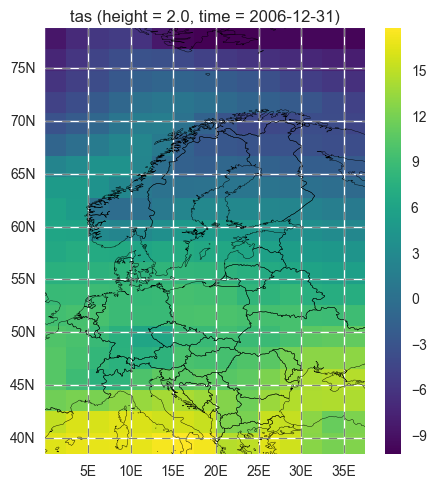

In [7]:
# Map showing clipped extent
ds3['tas'][0].salem.quick_map()

In [8]:
# Snap raster defining extent and cell size for desired output
tif_path = r'C:\Data\James_Work\Staff\Leah_JB\ECCO-DomQua\GIS\Shapefiles\chem_TOC_idw_n24_p1_clip.tif'
gtif = salem.open_xr_dataset(tif_path)
gtif

<xarray.Dataset>
Dimensions:  (x: 64, y: 77)
Coordinates:
  * y        (y) float64 2e+06 1.975e+06 1.95e+06 1.925e+06 1.9e+06 ...
  * x        (x) float64 3.25e+05 3.5e+05 3.75e+05 4e+05 4.25e+05 4.5e+05 ...
Data variables:
    data     (y, x) float32 2.18604 2.15718 1.92866 1.88092 1.87324 1.87352 ...
Attributes:
    pyproj_srs: +lon_0=15 +ellps=WGS84 +y_0=1000000 +no_defs=True +proj=aea +x_0=1000000 +units=m +lat_2=73 +lat_1=53 +lat_0=63 

These co-ordinates are for the cell edges, but we really want to interpolate to the cell centres.

In [9]:
# Adjust gtif co-ords to cell centres
gtif['x'] = gtif['x'] + 12500
gtif['y'] = gtif['y'] - 12500
gtif

<xarray.Dataset>
Dimensions:  (x: 64, y: 77)
Coordinates:
  * y        (y) float64 1.988e+06 1.962e+06 1.938e+06 1.912e+06 1.888e+06 ...
  * x        (x) float64 3.375e+05 3.625e+05 3.875e+05 4.125e+05 4.375e+05 ...
Data variables:
    data     (y, x) float32 2.18604 2.15718 1.92866 1.88092 1.87324 1.87352 ...
Attributes:
    pyproj_srs: +lon_0=15 +ellps=WGS84 +y_0=1000000 +no_defs=True +proj=aea +x_0=1000000 +units=m +lat_2=73 +lat_1=53 +lat_0=63 

In [10]:
# Reproject (and clip) to desired output
ds_pr = gtif.salem.transform(ds3)#, interp='spline')
ds_pr

<xarray.Dataset>
Dimensions:  (time: 10, x: 64, y: 77)
Coordinates:
  * y        (y) float64 1.988e+06 1.962e+06 1.938e+06 1.912e+06 1.888e+06 ...
  * x        (x) float64 3.375e+05 3.625e+05 3.875e+05 4.125e+05 4.375e+05 ...
  * time     (time) datetime64[ns] 2006-12-31 2007-12-31 2008-12-31 ...
    height   float64 2.0
Data variables:
    tas      (time, y, x) float64 nan nan nan nan nan nan -4.645 -4.645 ...
    pr       (time, y, x) float64 nan nan nan nan nan nan 113.7 113.7 113.7 ...
Attributes:
    pyproj_srs: +lon_0=15 +ellps=WGS84 +y_0=1000000 +no_defs=True +proj=aea +x_0=1000000 +units=m +lat_2=73 +lat_1=53 +lat_0=63 

**Note that using interp='spline' in the call above gives a much smoother result, but for the example here I've used "nearest neighbour" as I want the results to be direcyly comparable for checking (see below)**.

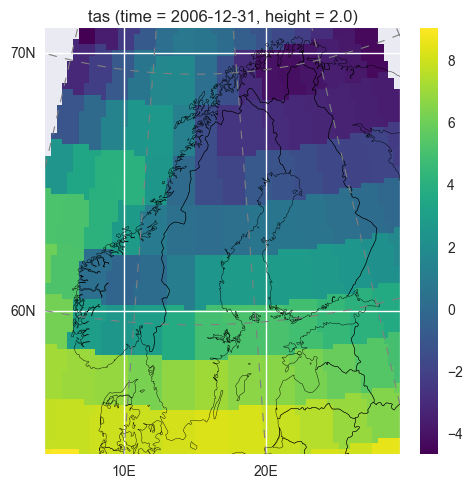

In [11]:
# Plot
ds_pr['tas'][0].salem.quick_map()

Checking. Compare time series for Oslo region (lat=60, lon=11).

In [12]:
# Get the time series for this location from the original ds
ds_pt = ds['tas'].sel_points(lon=[11],
                             lat=[60],
                             method='nearest')

# Convert to dataframe
df = ds_pt.to_dataframe().reset_index()
df.index = df['time']
df = df[['tas']]

df['tas'] = df['tas'] - 273.15

# Resample to annual averages
df = df.resample('A').mean()
df

,tas
time,
2006-12-31,3.006727
2007-12-31,4.300023
2008-12-31,3.227525
2009-12-31,3.195153
2010-12-31,1.593372
2011-12-31,3.158765
2012-12-31,3.910123
2013-12-31,3.704030
2014-12-31,2.992357


Compare to results from processed file.

In [13]:
# Convert co-ords
p1 = pyproj.Proj(init='epsg:4326')
p2 = pyproj.Proj(ds_pr.salem.grid.proj.srs)
x, y = pyproj.transform(p1, p2, 11, 60)
print '%.3f %.3f' % (x, y)

779666.199 667817.578


In [14]:
# Get the time series for this location from the processed ds
ds_pt = ds_pr['tas'].sel_points(x=[x],
                                y=[y],
                                method='nearest')

# Convert to dataframe
df2 = ds_pt.to_dataframe().reset_index()
df2.index = df2['time']
df2 = df2[['tas']]

# Resample to annual averages
df2 = df2.resample('A').mean()
df2

,tas
time,
2006-12-31,3.006727
2007-12-31,4.300023
2008-12-31,3.227525
2009-12-31,3.195153
2010-12-31,1.593372
2011-12-31,3.158765
2012-12-31,3.910123
2013-12-31,3.704030
2014-12-31,2.992357


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000018D2F518>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000000D04EEB8>], dtype=object)

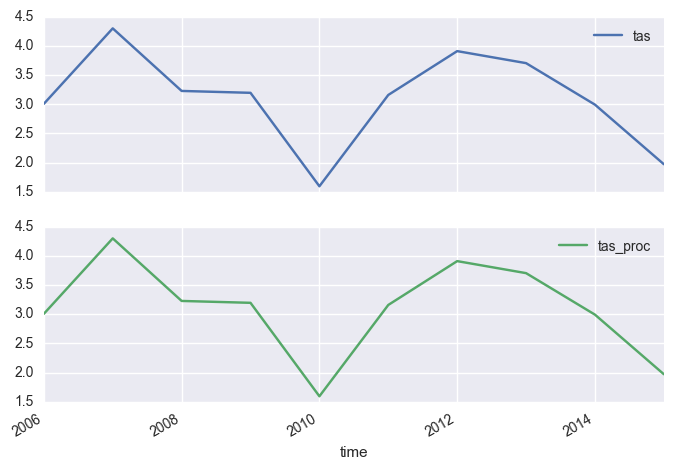

In [15]:
df = df.join(df2, rsuffix='_proc')
df.plot(subplots=True)

In [42]:
def array_to_gtiff(xmin, ymax, cell_size, out_path, data_array,
                   proj4_str, no_data_value=-9999):
    """ Save numpy array as GeoTiff (in a projected co-ordinate system).
    
    Args:
        xmin:          Minimum x value in metres
        ymax:          Maximum y value in metres
        cell_size:     Grid cell size in metres
        out_path:      Path to GeoTiff
        data:          Array to save 
        proj4_str      proj.4 string defining the projection
        no_data_value: Value to use to represent no data 
        
    Returns:
        None. Array is saved to specified path.
    """
    # Import modules
    import gdal, gdalconst, osr

    # Explicitly set NDV
    data_array[np.isnan(data_array)] = no_data_value
    
    # Flip. Not sure why this is necessary? Without it the 
    # output grid is upside down! Haven't had this problem before,
    # but this seems to work here. Beware in future!
    #data_array = data_array[::-1,:]

    # Get array shape
    cols = data_array.shape[1]
    rows = data_array.shape[0]

    # Get driver
    driver = gdal.GetDriverByName('GTiff')

    # Create a new raster data source
    out_ds = driver.Create(out_path, cols, rows, 1, gdal.GDT_Float32)

    # Get spatial reference
    sr = osr.SpatialReference()
    sr.ImportFromProj4(proj4_str)
    sr_wkt = sr.ExportToWkt()

    # Write metadata
    # (xmin, cellsize, 0, ymax, 0, -cellsize)
    out_ds.SetGeoTransform((int(xmin), cell_size, 0.0, 
                            int(ymax), 0.0, -cell_size)) 
    out_ds.SetProjection(sr_wkt)
    out_band = out_ds.GetRasterBand(1)
    out_band.SetNoDataValue(-9999)
    out_band.WriteArray(data_array)

    # Tidy up
    del out_ds, out_band

In [43]:
# Write each temp grid to GeoTiff
out_fold = r'C:\Data\James_Work\Staff\Leah_JB\ECCO-DomQua\Climate_Data\test'

for tm in ds_pr['time']:
    year = pd.to_datetime(tm.values).year
    ar = ds_pr['tas'].sel(time=time).values
    out_path = os.path.join(out_fold, 'tas_%s.tif' % year)
    array_to_gtiff(325000, 2000000, 25000, out_path, ar,
                   ds_pr.salem.grid.proj.srs)